# BioEn Spin-Label Enemble Refinement with DEER Data

This notebook shows how to perform spin-label ensemble refinement with DEER data using BioEn. The steps of the Jupyter notebook are <br> 

1. Preparation of the input <br> 
2. BioEn <br> 
3. Analysis of the BioEn results<br> 

You can either use the provided test data or define your own protein of interest, use your own rotamer library, and define labeled position of interest. 

Executing this notebook may take a little while, as it reproduces the key computations from Reichel et al., 2018.

### Theory and methods applied in this Jupyter notebook are available in:
K. Reichel, Lukas S. Stelzl, J. Köfinger, G. Hummer, “Precision DEER Distances from Spin-Label Reweighting“, J. Phys. Chem. Lett., 9, 5748--5752  (2018). https://pubs.acs.org/doi/10.1021/acs.jpclett.8b02439

G. Hummer, J. Köfinger, “Bayesian ensemble refinement by replica simulations and reweighting”, J. Chem. Phys. 143, 243150 (2015). https://doi.org/10.1063/1.4937786

### Experimental DEER data used in this Jupyter notebook are published in:
R. Dastvan, E. Brouwer, D. Schuetz, O. Mirus, E. Schleiff, T.F. Prisner, ”Relative orientation of POTRA domains from cyanobacterial Omp85 studied by pulsed EPR spectroscopy”, Biophys. J. 110, 2195--2206 (2016). https://doi.org/10.1016/j.bpj.2016.04.030

In [1]:
import numpy as np
import pickle
import pandas as pd

import MDAnalysis as mda
import MDAnalysis.analysis.align
import MDAnalysis.lib.NeighborSearch as KDNS
import MDAnalysis.analysis.distances

from scipy.special import fresnel

import matplotlib as m
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import bioen_rotamer as br

%matplotlib inline

/home/tb/lustelzl/.local/lib/python2.7/site-packages/MDAnalysis/due.py:88: UserWarning: No module named duecredit
  warnings.warn(str(err))


## Define paths to the experimental and simulated data and for the output of preparation, BioEn, and analysis of the BioEn runs

In [2]:
%%capture
! mkdir files/output_preparation
! mkdir files/output_bioen
! mkdir files/output_analysis

# path to experimental data
path_experimental_data = "files/experimental_data/"

# path to simulated data
path_simulated_data = "files/simulated_data/"

# define path to the output of the preparation
path_output_preparation = "files/output_preparation"

# define path to the output of BioEn
path_output_bioen = "files/output_bioen"

# define path to the output of the analysis
path_output_analysis = "files/output_analysis"

# Preparation

## Settings and input parameters for preparation

In [3]:
# use the protein of interest (here: crystal structure of the POTRA domains)
structure = "files/pdb_structure/3MC8_xray.pdb"

# pdb of the label (here: MTSL), trajectory and weights of the rotamer library
rotamer_library_pdb = "files/rotamer_library/rotamer1_R1A_298K_2015.pdb"
rotamer_library_dcd = "files/rotamer_library/rotamer1_R1A_298K_2015.dcd"
rotamer_library_weights = "files/rotamer_library/rotamer1_R1A_298K_weights_2015.dat"

# spin label positions to obtain rotamer states
spin_labels = [[259, 'A'], [265, 'A'], [292, 'A'],              # P1 domain   
               [319, 'C'], [344, 'C'], [374, 'C'], [370, 'C'],  # P2 domain
               [429, 'E'], [448, 'E'], [457, 'E'], [460, 'E']]  # P3 domain

# spin_label_pairs used for the spin-label reweighting
spin_label_pairs = [[[370, 'C'], [292, 'A']],
                    [[319, 'C'], [292, 'A']],                                                                                
                    [[344, 'C'], [292, 'A']],
                    [[370, 'C'], [292, 'A']],
                    [[319, 'C'], [265, 'A']],
                    [[344, 'C'], [265, 'A']],
                    [[370, 'C'], [265, 'A']],
                    [[319, 'C'], [259, 'A']],
                    [[344, 'C'], [259, 'A']],
                    [[370, 'C'], [259, 'A']],
                    [[374, 'C'], [259, 'A']],
                    [[374, 'C'], [292, 'A']],
                    [[292, 'A'], [460, 'E']],
                    [[259, 'A'], [457, 'E']],
                    [[259, 'A'], [448, 'E']],
                    [[344, 'C'], [429, 'E']],
                    [[344, 'C'], [460, 'E']],
                    [[319, 'C'], [460, 'E']],
                    [[370, 'C'], [460, 'E']],
                    [[319, 'C'], [429, 'E']],
                    [[370, 'C'], [429, 'E']]]

# clash_distance between atoms of the spin-spin label and the protein
clash_distance = 1.4

## Obtain for each labeled position a trajectory of spin-label rotamers

In [4]:
def get_rotamers():
    """
    Calculates for each spin-label position possible rotameric states
    according to the protein structure.
       
    Returns
    -------
    rotamer_labels: dict
        For each spin-label position an array with boolean entries 
        for each rotameric state
    """
    xray = mda.Universe(structure)
    rotamers = mda.Universe(rotamer_library_pdb, rotamer_library_dcd)

    rotamer_labels = dict()
    for label in spin_labels:
        resid = label[0]
        chainid = label[1]
        dcd_fn = '{}/tmp_traj_{}_{}.dcd'.format(path_output_preparation, resid, chainid)
        d = dict()
        br.fit_rotamers(rotamers, xray, resid, chainid, dcd_fn)
        rotamer_site = mda.Universe(rotamers.filename, dcd_fn)
        rotamer_clash = br.find_clashing_rotamers(clash_distance, rotamer_site, xray, resid, chainid)
        d['site'] = rotamer_site
        d['clash'] = rotamer_clash

        rotamer_nitrogen = rotamer_site.select_atoms("name N1")
        rotamer_oxygen = rotamer_site.select_atoms("name O1")
        rotamer_positions = dict()
        for rotamer in rotamer_site.trajectory:
             if not rotamer_clash[rotamer.frame]:
                rotamer_electron = (np.array(rotamer_nitrogen.positions[0][0:3]) + np.asarray(rotamer_oxygen.positions[0][0:3]))/2.0
                rotamer_positions[rotamer.frame] = [rotamer_electron]
        d['positions'] = rotamer_positions
        ln = '{}-{}'.format(resid, chainid)
        rotamer_labels[ln] = d
    return rotamer_labels

In [5]:
rotamer_labels = get_rotamers()

Step   216/216 [100.0%]
Step   216/216 [100.0%]
Step   216/216 [100.0%]
Step   216/216 [100.0%]
Step   216/216 [100.0%]
Step   216/216 [100.0%]
Step   216/216 [100.0%]
Step   216/216 [100.0%]
Step   216/216 [100.0%]
Step   216/216 [100.0%]
Step   216/216 [100.0%]


## Get for each spin-label distance in the rotamer trajectories a single DEER trace

In [6]:
def get_preparation_output(rotamer_labels, rotamer_library_weights, path_output_preparation):
    """
    Generates all needed input files for BioEn 
        data_*.pkl --> DEER traces based on spin-label distances
        models_*.dat --> list of the model ids
        frames_*.pkl --> spin-label rotamers and spin-label distances
    """   
    for spin_label_pair in spin_label_pairs:
        label_pair_id = [spin_label_pair[0][0], spin_label_pair[1][0]]
        ts = br.get_experimental_timesteps(path_experimental_data, label_pair_id)
        spin_label_pair.append(ts)
        br.get_deer_from_single_pair(spin_label_pair, rotamer_labels, rotamer_library_weights, path_output_preparation)    
    return

In [7]:
get_preparation_output(rotamer_labels, rotamer_library_weights, path_output_preparation)

Generated files are saved in files/output_preparation:
	data_370-292.pkl --> DEER traces based on spin-label distances
	models_370-292.dat --> list of the model ids
	frames_370-292.pkl --> spin-label rotamers and spin-label distances
Generated files are saved in files/output_preparation:
	data_319-292.pkl --> DEER traces based on spin-label distances
	models_319-292.dat --> list of the model ids
	frames_319-292.pkl --> spin-label rotamers and spin-label distances
Generated files are saved in files/output_preparation:
	data_344-292.pkl --> DEER traces based on spin-label distances
	models_344-292.dat --> list of the model ids
	frames_344-292.pkl --> spin-label rotamers and spin-label distances
Generated files are saved in files/output_preparation:
	data_370-292.pkl --> DEER traces based on spin-label distances
	models_370-292.dat --> list of the model ids
	frames_370-292.pkl --> spin-label rotamers and spin-label distances
Generated files are saved in files/output_preparation:
	data_319

# BioEn

Now that we calculated DEER time traces for the different ensemble members, we can start to refine the ensemble against experimental data.

## Settings and input parameters for BioEn

In [8]:
# define theta series, BioEn performs for each theta a single reweighting
#theta_series = [10e5, 10e4, 10e3, 10e2, 10e1, 10e0, 10e-1, 0]

# here: we use single theta 
theta_series = [1000.0]
np.savetxt('theta.dat', np.array(theta_series))

## Run BioEn with bash script and use files generated in the preparation

In [9]:
def run_bioen_script(label_pair_id, nmodels):
    ! bash run_bioen_ipynb_deer.sh $label_pair_id $nmodels 
    return

In [10]:
#%%capture c
for spin_label_pair in spin_label_pairs:
    label_pair_id = '{}-{}'.format(spin_label_pair[0][0], spin_label_pair[1][0])
    
    #get number of ensemble members = nmodels
    nmodels = len(np.loadtxt('{}/models_{}.dat'.format(path_output_preparation, label_pair_id)))          
    # start BioEn reweighting for each spin-label pair
    run_bioen_script(label_pair_id, nmodels)

INFO:root:BioEn weight refinement starts with
INFO:root:    optimization method: log-weights
INFO:root:    optimization algorithm: bfgs
INFO:root:    optimization minimizer: GSL
INFO:root:BioEn finished weight refinement in 20.79 s.
INFO:root:BioEn weight refinement starts with
INFO:root:    optimization method: log-weights
INFO:root:    optimization algorithm: bfgs
INFO:root:    optimization minimizer: GSL
INFO:root:BioEn finished weight refinement in 38.53 s.
INFO:root:BioEn weight refinement starts with
INFO:root:    optimization method: log-weights
INFO:root:    optimization algorithm: bfgs
INFO:root:    optimization minimizer: GSL
INFO:root:BioEn finished weight refinement in 25.63 s.
INFO:root:BioEn weight refinement starts with
INFO:root:    optimization method: log-weights
INFO:root:    optimization algorithm: bfgs
INFO:root:    optimization minimizer: GSL
INFO:root:BioEn finished weight refinement in 20.48 s.
INFO:root:BioEn weight refinement starts with
INFO:root:    optimiza

# Analysis

## Settings and input parameters for analysis of BioEn outputs

In [11]:
def load_bioen_pkl(label_pair_id):
    """
    Loads output of BioEn pkl file (contains all information)
    """
    df = pd.read_pickle("{}/bioen_{}.pkl".format(path_output_bioen, label_pair_id))
    return df.to_dict()

In [12]:
def get_frames(label_pair_id):
    """
    Loads frames file (contains information on rotamer states and distances)
    """
    frames_pkl = '{}/frames_{}.pkl'.format(path_output_preparation, label_pair_id)
    with open(frames_pkl, 'r') as file:
        [frames_dict] = pickle.load(file)
    return frames_dict

In [13]:
bioen_data = dict()
frames_data = dict()
for spin_label_pair in spin_label_pairs:
    label_pair_id = '{}-{}'.format(spin_label_pair[0][0], spin_label_pair[1][0])
    bioen_data[label_pair_id] = load_bioen_pkl(label_pair_id)
    frames_data[label_pair_id] = get_frames(label_pair_id)

`bioen_data` contains all needed and useful information to analyse the BioEn calculations. <br>
For each previously defined confidence value $\theta$ (defined in the variable `theta_series`) a list of BioEn output is available:

**Experimental information**
- **`exp`** <br> 
--> experimental DEER signals for each label <br>
--> in case of DEER data, this variable contains time, DEER signal and polynomial fit of the DEER signal <br>
--> time: `data['exp']['370-292'][:,0]` <br>
--> DEER trace: `data['exp']['370-292'][:,1]` <br>
--> polynomial fit of DEER trace: `data['exp']['370-292'][:,1]` <br>
- **`exp_err`** <br>
--> error/noise of each experimental data point defined in `exp`
- **`labels`** <br> 
--> list of labels used in the refinement
- **`nrestraints`** <br>
--> number of data points ($M$)

**Simulated data and parameters**
- **`sim_init`** <br> 
--> initial ensemble averaged simulated DEER traces for each label (see above for exp)
- **`sim_wopt`** <br>
--> optimized ensemble averaged simulated DEER traces for each label and for a given confidence value $\theta$
- **`moddepth`** <br>
--> modulation depth of the optimized ensemble averaged simulated DEER traces for each label 
- **`nmodels_list`** <br>
--> list of model ids (extracted e.g. from models_370-292.dat)
- **`nmodels`** <br>
--> number of models ($N$), which is also the number of ensemble members (relevant in the BioEn context) <br>
--> `nmodels` = `nrotamers` <br>
--> number of rotamers, which is needed to backcalculate weights of rotamers of a spin-label position (relevant in the analysis contex) <br>

**Free energy parameters**
- **`theta`** <br>
--> confidence parameter $\theta$
- **`chi2_init`** <br>
--> deviation from the experimental data with the initial weight distribution <br>
--> if you use `chi2_init` of the maximal value of $\theta$, $\chi^2$ is calculated with the prior weight distribution `w0`
- **`chi2`** <br>
--> optimal $\chi^2$ calculated with optimal weight distribution `wopt`
- **`S_init`** <br>
--> initial relative entropy
--> if you use `S_init` of the maximal value of $\theta$, $S$ is equal to $0$
- **`S`** <br>
--> relative entropy of optimized weight distribution
- **`w0`** <br>
--> reference weight distribution
- **`winit`** <br>
--> initial weight distribution
- **`wopt`** <br>
--> optimal weight distribution <br>
--> optimized for each $\theta$

**Misc**
- **`len_sim`** <br>
--> seconds it took for BioEn to optimize for a given value of $\theta$
- **`optimization_method`** <br>
--> information about the optimization method: log-weights or forces
- **`optimization_minimizer`** <br>
--> information about the minimer: scipy, GSL, LBFGS
- **`optimization_algorithm`** <br>
--> information about the inimizer: <br>
--> scipy: bfgs, lbfgs, cg <br>
--> GSL: conjugate_fr, conjugate_pr, bfgs, bfgs, steepest_descent<br>
--> LBFGS: lbfgs <br>

# Plot all experimental and ensemble averaged DEER traces

('chi2_xray_average', 4.9745953067270783)
('chi2_bioen_average', 0.57647978713546166)


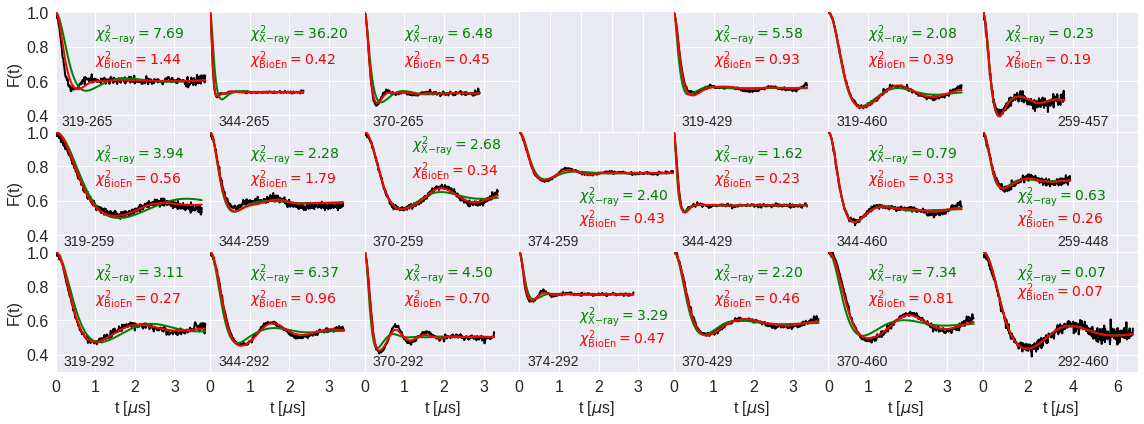

In [14]:
br.plot_deer_traces(bioen_data)

This reproduces Figure 2 of Reichel et al. 2018. See https://pubs.acs.org/doi/10.1021/acs.jpclett.8b02439

Refining spin-label positions gives a substantial improvement in the agreement with experiment. Encouragingly, this improvement requires only minor modifications in the weights of the spin-labels, as is discussed in more detail in the manuscript.

## Rotamer distribution of spin-label positions

In [15]:
def get_rotamer_distribution(spin_label_pair):
    """
    Margenalize rotamer weights for each spin-label of each spin-label pair.
    """
    label_pair_id = '{}-{}'.format(spin_label_pair[0][0], spin_label_pair[1][0])
    rotamer_weights = dict()
    for label in [spin_label_pair[0][0], spin_label_pair[1][0]]:
        rotamer_weights[label] = br.get_weighted_rotamer_states(frames_data[label_pair_id], 
                                                                bioen_data[label_pair_id], 
                                                                label, theta=1000.0)
    return rotamer_weights

In [16]:
rotamer_weights_all = dict()
for spin_label_pair in spin_label_pairs:
    label_pair_id = '{}-{}'.format(spin_label_pair[0][0], spin_label_pair[1][0])
    rotamer_weights_all[label_pair_id] = get_rotamer_distribution(spin_label_pair)

### Write pdbs 
- with the rotamer states (position of the unpaired electron between the nitroxidide N and O)
- the cummulative weight of that rotamer states as the B-factor

In [17]:
def write_rotamer_pdb(label_pair_id, label_resid_chain_id, label):
    """
    Write margenalize rotamer weights for each spin-label of each spin-label pair into a pdb with 
    the coordinates of the unpaired electron for each possible rotameric state.
    """
    rotamer_positions = rotamer_labels[label_resid_chain_id]["positions"]
    rotamer_pdb = "{}/weighted_rotamers_{}_{}.pdb".format(path_output_analysis, label_pair_id, label)
    pdb = open(rotamer_pdb, 'w')

    w_check = []
    for frame, weights in rotamer_weights_all[label_pair_id][label].iteritems():
        w_check.append(np.sum(weights))
        x = rotamer_positions[frame][0][0]
        y = rotamer_positions[frame][0][1]
        z = rotamer_positions[frame][0][2]
        line =  "ATOM   {:4d}  O   ALA A{:4d}    {:8.3f}{:8.3f}{:8.3f}     {:6.8f}     \n".format(int(frame), 
                                                                                                  int(frame), 
                                                                                                  x, y, z, 
                                                                                                  np.sum(weights))
        pdb.write(line)
    pdb.close()
    return

In [18]:
for spin_label_pair in spin_label_pairs:
    label_pair_id = '{}-{}'.format(spin_label_pair[0][0], spin_label_pair[1][0])
    for label_resid_chain in spin_label_pair[0:2]:
        label_resid_chain_id = '{}-{}'.format(label_resid_chain[0], label_resid_chain[1])
        label = label_resid_chain[0]
        write_rotamer_pdb(label_pair_id, label_resid_chain_id, label)